In [ ]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # use GPU
print(device)

cuda:0


## Dataset 생성

In [ ]:
mnist_transform=transforms.Compose([
                              transforms.Resize((28,28)),
                              transforms.ToTensor(), # first, convert image to PyTorch (float) tensor
                              transforms.Normalize((0.5,), (0.5,)) # normalize inputs
                              ])

train_dataset = datasets.MNIST(root='D:\Dropbox\Teaching\ML\Assignment\Assignment 3/mnist_data', 
                                  train=True, 
                                  download=True, 
                                  transform=mnist_transform)

# validation or test dataset loading
validation_dataset = datasets.MNIST(root='D:\Dropbox\Teaching\ML\Assignment\Assignment 3/mnist_data', 
                                  train=False, 
                                  download=True, 
                                  transform=mnist_transform)

# print(train_dataset)
# print(validation_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True) # shuffle training data before each epoch to avoid local min
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)







0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to D:\Dropbox\Teaching\ML\Assignment\Assignment 3/mnist_data\MNIST\raw\train-images-idx3-ubyte.gz


HTTPError: HTTP Error 503: Service Unavailable

## CNN Model Define

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()        
        # self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 30, 
        #                       kernel_size = 5, stride = 1, padding = 0)
        # self.conv2 = nn.Conv2d(in_channels = 30, out_channels = 30, 
        #                       kernel_size = 3, stride = 1, padding = 0)       
        
        self.fc1 = nn.Linear(28*28, 250)        #for NN        
        self.fc2 = nn.Linear(250, 10)

    def forward(self, x):
        # x = F.relu(self.conv1(x))
        # x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        # x = F.relu(self.conv2(x))
        # x = F.max_pool2d(x, kernel_size = 2, stride = 2)

        x = x.view(-1, 28*28)    # flattening, torch.Size([100 (batch), 28*28])   for NN        
        x = F.relu(self.fc1(x))        
        x = self.fc2(x)     # activation not needed    # multi class classification -> raw output instead of softmax applied 
        return x

In [ ]:
torch.manual_seed(1)
model = CNN().to(device) # use GPU
model

CNN(
  (fc1): Linear(in_features=784, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=10, bias=True)
)

# calculate only the number of the trainable parameters
- to sum the number of elements for every parameter group:
- torch. numel ( input ) → int, Returns the total number of elements in the input tensor.
- if want to calculate only the trainable parameters: if p.requires_grad

In [ ]:
# no_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(no_total_params)

from prettytable import PrettyTable
def count_parameters(model):
  table = PrettyTable(["Modules", "Parameters"])
  total_params = 0
  for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    param = parameter.numel()
    table.add_row([name, param])
    total_params+=param
  print(table)
  print('Total Trainable Params: {}'.format(total_params))
  return total_params
    
count_parameters(model)

+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |   196000   |
|  fc1.bias  |    250     |
| fc2.weight |    2500    |
|  fc2.bias  |     10     |
+------------+------------+
Total Trainable Params: 198760


198760

## Model Training

In [ ]:
# "torch.nn.CrossEntropyLoss" criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class
# Softmax + CrossEntropy (logSoftmax + NLLLoss)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

# Calculate the elapsed time
t0 = int(round(time.time()))

for eno in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0

  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in train_loader: # a batch of 100 images X 600 batches -> 60,000 for a single epoch, train_loader has 600 items
    inputs = inputs.to(device)  # use GPU
    labels = labels.to(device)  # use GPU

    #print(inputs.shape) #torch.Size([100, 1, 28, 28])
    inputs = inputs.view(inputs.shape[0], -1)  # [100(batch size), 1, 28, 28] => [100(leave it as it is), 784]  # for NN model
    outputs = model(inputs)
    loss = criterion(outputs, labels) # Tensors: outputs [100, 1], labels [100]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, pred_idx = torch.max(outputs, 1) # dim (int) – the dimension to reduce => out  (max, max_indices)
    #print(pred_idx)
    running_loss += loss.item() # loss per batch
    running_corrects += torch.sum(pred_idx == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)  # use GPU
        val_labels = val_labels.to(device)  # use GPU

        val_inputs = val_inputs.view(val_inputs.shape[0], -1) # for NN model
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(train_loader) #  sum(running_loss per batch), train_loader has 600 items -> epoch loss
    epoch_acc = running_corrects.float()/ len(train_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    print('--------epoch :', (eno+1), '-----------------------')
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)    
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

print('Time elapsed {}seconds'.format(int(round(time.time())) - t0))

--------epoch : 1 -----------------------
training loss: 0.3828, acc 88.7217 
validation loss: 0.2118, validation acc 93.9100 
--------epoch : 2 -----------------------
training loss: 0.1863, acc 94.3983 
validation loss: 0.1501, validation acc 95.5100 
--------epoch : 3 -----------------------
training loss: 0.1299, acc 96.0867 
validation loss: 0.1203, validation acc 96.2700 
--------epoch : 4 -----------------------
training loss: 0.1029, acc 96.8683 
validation loss: 0.0979, validation acc 97.1000 
--------epoch : 5 -----------------------
training loss: 0.0865, acc 97.3467 
validation loss: 0.0822, validation acc 97.2900 
--------epoch : 6 -----------------------
training loss: 0.0734, acc 97.7367 
validation loss: 0.0878, validation acc 97.1800 
--------epoch : 7 -----------------------
training loss: 0.0650, acc 97.9700 
validation loss: 0.0784, validation acc 97.6200 
--------epoch : 8 -----------------------
training loss: 0.0597, acc 98.1517 
validation loss: 0.0799, validati

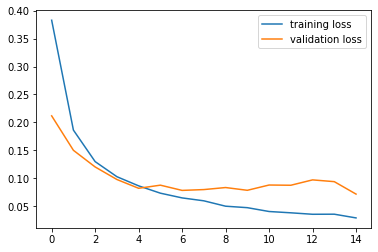

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

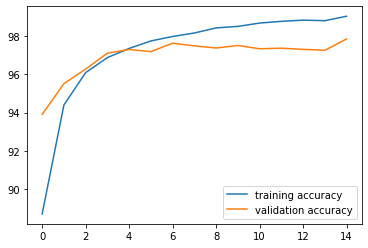

In [ ]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

## 결과 시각화

In [ ]:
def fConvertImg(tensor):# from tensor to numpy image to plot
  # can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
  image = tensor.cpu().clone().detach().numpy() # [1, 28, 28] channel, width, height, Since in general for a copy operation one wants a clean copy which can't lead to unforeseen side effects the preferred way to copy a tensors is .clone().detach() than .copy_(x)
  image = image.transpose(1, 2, 0)        # [28, 28, 1], swap axis 0->1,  1->2, 2->0 , print(image.shape) => (28, 28, 1)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))  # de-nomalization     x' = x-u/sigma  -> x = x'*sigma + u
  image = image.clip(0, 1)  # clip image intensity between min (0) & max (1)
  return image

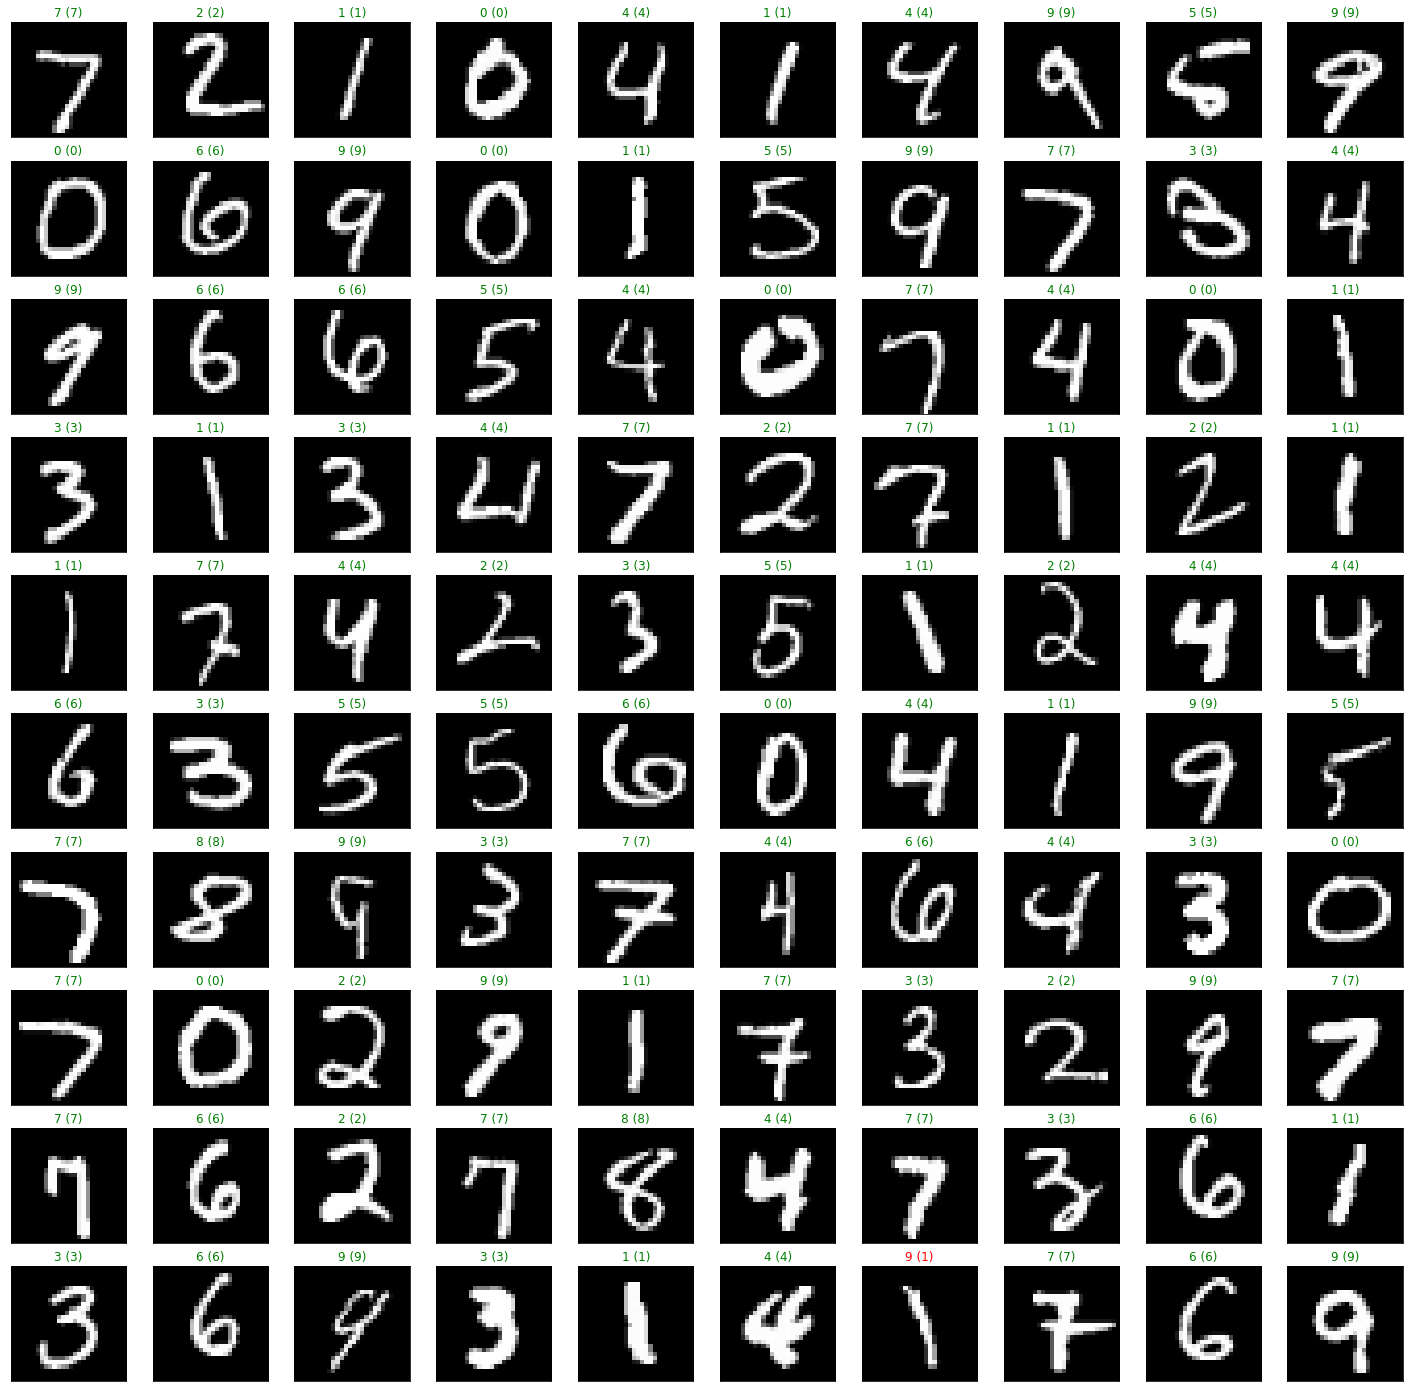

In [ ]:
dataiter = iter(validation_loader) # iter() returns an iterator for the given iterable object.
images, labels = dataiter.next()

images = images.to(device)  # use GPU
labels = labels.to(device)  # use GPU

output = model(images.view(images.shape[0], -1))    # for NN model
# output = model(images)                            # for CNN model
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 25))

for idx in np.arange(len(dataiter)):
  ax = fig.add_subplot(10, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(fConvertImg(images[idx]))  
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))